## Table of Contents

1. [Imports and Setup](#Imports-and-Setup)
2. [Data Ingestion](#Data-Ingestion)
3. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Predictor Development](#Predictor-Development)
6. [Summary and Future Work](#Summary-and-Future-Work)

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib
matplotlib.use('Agg')  # Needed for matplotlib in some environments
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Switch backend if only plt is imported
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set Seaborn style
sns.set(style="whitegrid")

# Print a startup message
print('Imports and setup complete.')

Imports and setup complete.


In [2]:
# Read the dataset
try:
    df = pd.read_csv('newborn_health_monitoring_with_risk.csv', encoding='ascii')
    
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print('Data loaded successfully. DataFrame shape:', df.shape)
except Exception as e:
    print('Error loading data:', e)
    raise

Data loaded successfully. DataFrame shape: (3000, 25)


In [3]:
## Data Cleaning and Preprocessing

# Quick look at the first rows of the data
print(df.head())

# Check for missing values
missing_vals = df.isnull().sum()
print('Missing values per column:\n', missing_vals)

# Basic statistical summary for numeric columns
print(df.describe())

# If there are any missing or wrongly formatted dates, warn the user
if df['date'].isnull().any():
    print('Warning: Some dates could not be parsed properly. This may affect time series analyses.')

# Convert categorical columns to category type
categorical_cols = ['baby_id', 'name', 'gender', 'feeding_type', 'immunizations_done', 'reflexes_normal', 'risk_level']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Ensure numeric columns are the correct dtype
numeric_cols = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm', 'birth_head_circumference_cm',
                'age_days', 'weight_kg', 'length_cm', 'head_circumference_cm', 'temperature_c', 'heart_rate_bpm',
                'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_frequency_per_day', 'urine_output_count',
                'stool_count', 'jaundice_level_mg_dl', 'apgar_score']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print('Data cleaning and preprocessing complete.')

  baby_id  name  gender  gestational_age_weeks  birth_weight_kg  \
0    B001  Sara  Female                   40.2              3.3   
1    B001  Sara  Female                   40.2              3.3   
2    B001  Sara  Female                   40.2              3.3   
3    B001  Sara  Female                   40.2              3.3   
4    B001  Sara  Female                   40.2              3.3   

   birth_length_cm  birth_head_circumference_cm       date  age_days  \
0             50.0                         31.9 2024-12-10         1   
1             50.0                         31.9 2024-12-11         2   
2             50.0                         31.9 2024-12-12         3   
3             50.0                         31.9 2024-12-13         4   
4             50.0                         31.9 2024-12-14         5   

   weight_kg  ...  oxygen_saturation   feeding_type  \
0       3.28  ...                 98        Formula   
1       3.35  ...                 99        Formula   

<Figure size 1200x600 with 0 Axes>

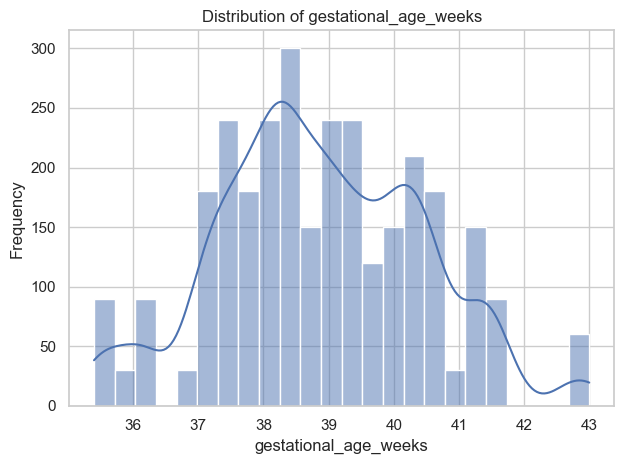

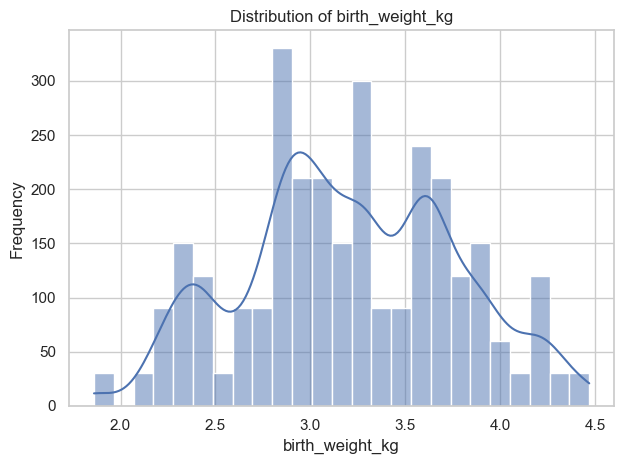

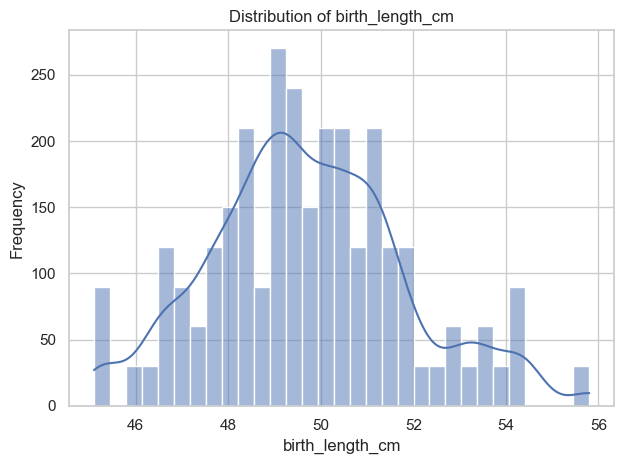

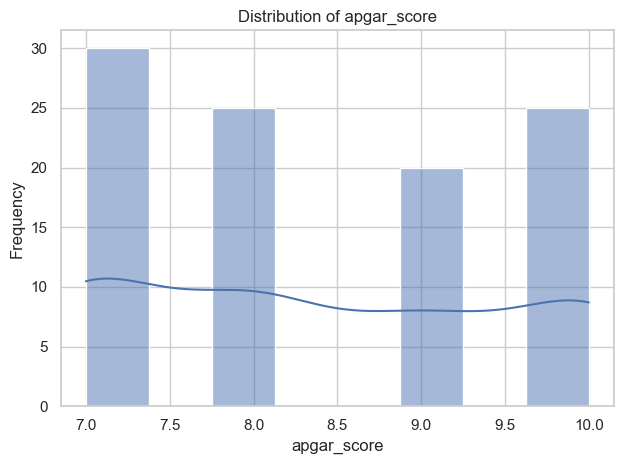

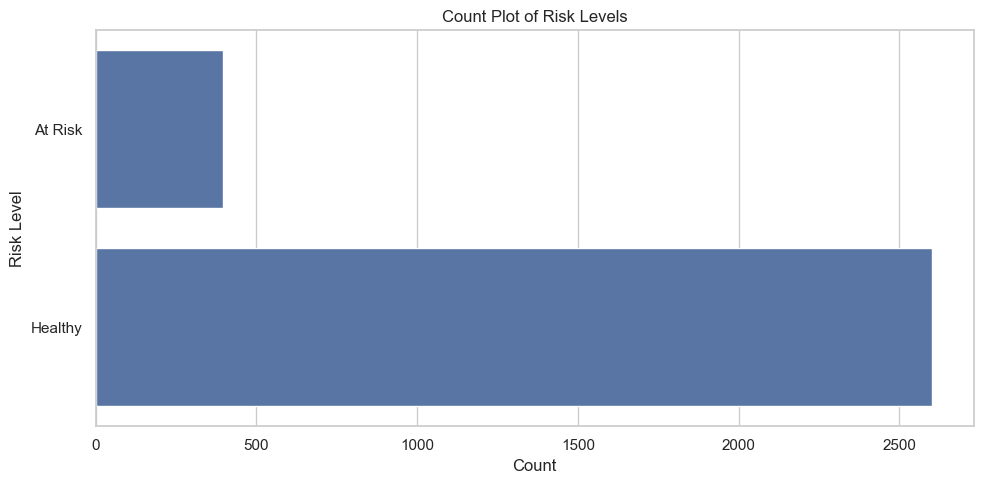

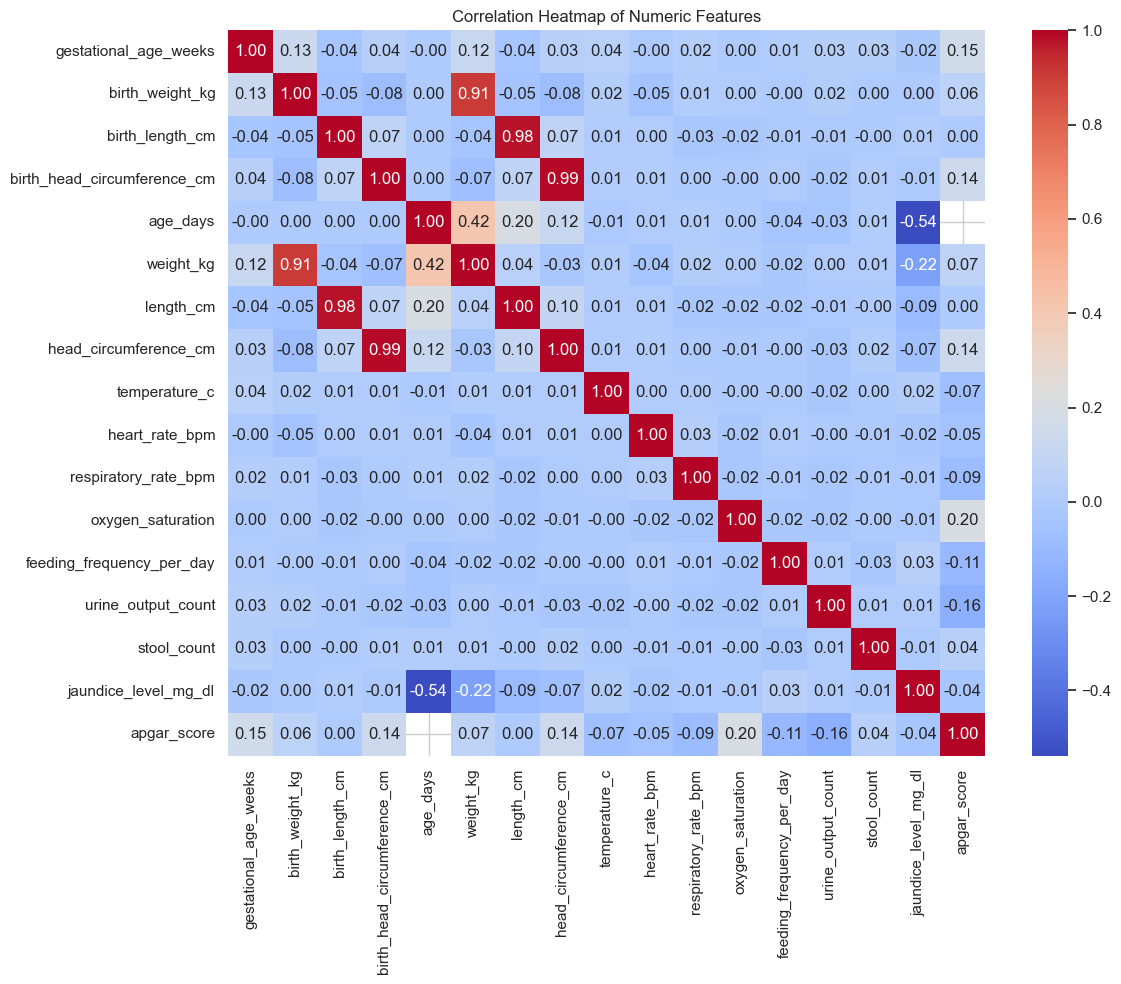

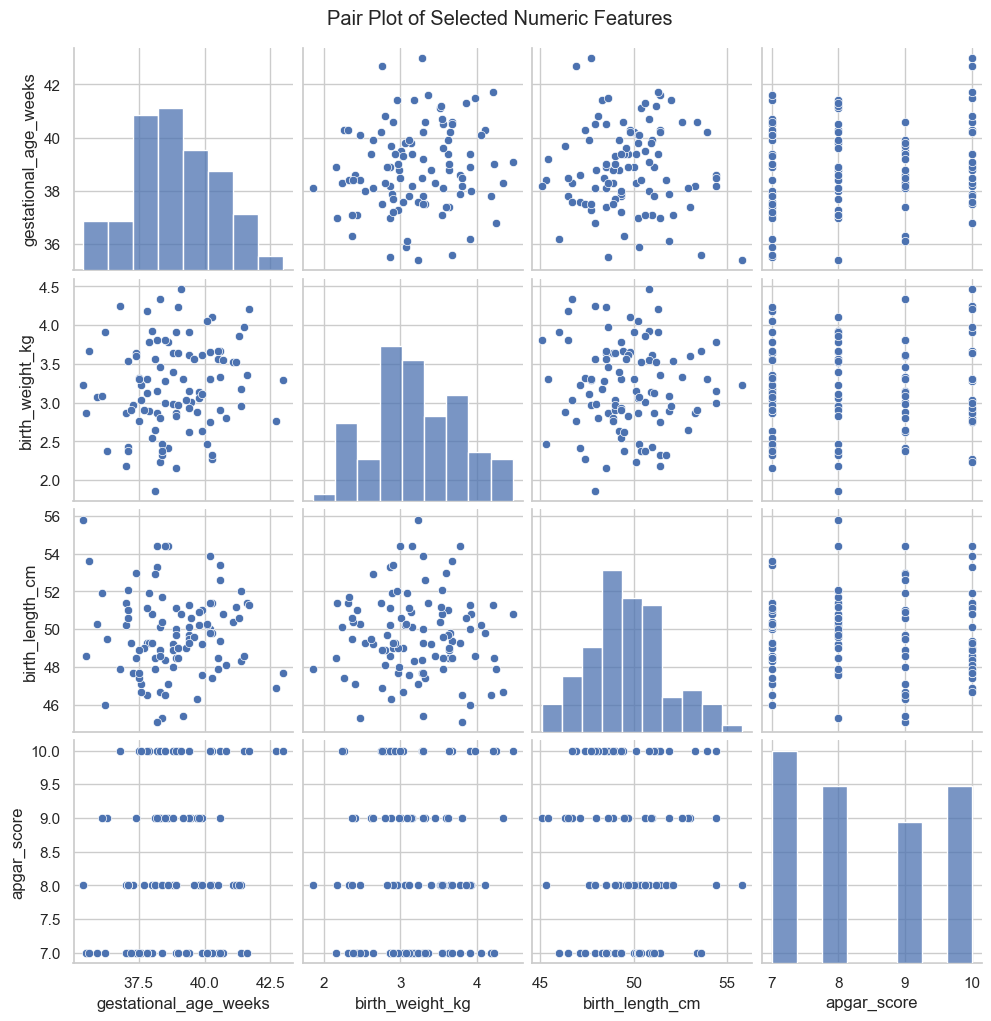

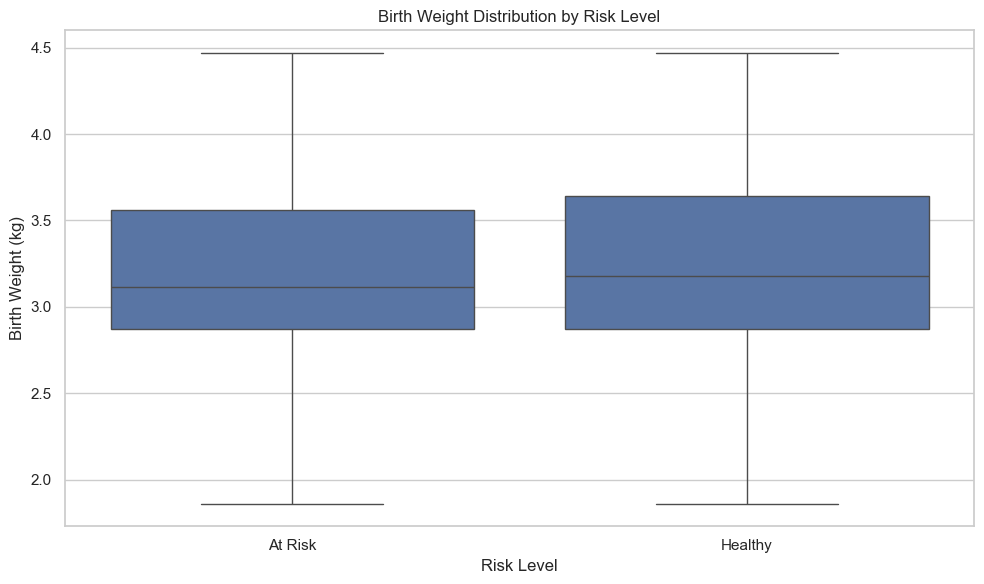

Exploratory Data Analysis complete.


In [4]:
## Exploratory Data Analysis

# Set the figure size for plots
plt.figure(figsize=(12, 6))

# 1. Numeric Variable Distributions (Histogram for a few chosen columns)
for col in ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm', 'apgar_score']:
    if col in df.columns:
        plt.figure()
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()

# 2. Categorical Variable Count (Pie/Count Plot)
plt.figure(figsize=(10, 5))
sns.countplot(y='risk_level', data=df)
plt.title('Count Plot of Risk Levels')
plt.xlabel('Count')
plt.ylabel('Risk Level')
plt.tight_layout()

# 3. Correlation Heatmap
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
else:
    print('Not enough numeric columns for correlation heatmap.')

# 4. Pair Plot for selected numeric variables
selected_vars = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm', 'apgar_score']
if all(var in df.columns for var in selected_vars):
    sns.pairplot(df[selected_vars].dropna())
    plt.suptitle('Pair Plot of Selected Numeric Features', y=1.02)
else:
    print('Some selected variables for pair plot are missing.')

# 5. Box Plot (Example: birth_weight_kg by risk_level)
if 'birth_weight_kg' in df.columns and 'risk_level' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_level', y='birth_weight_kg', data=df)
    plt.title('Birth Weight Distribution by Risk Level')
    plt.xlabel('Risk Level')
    plt.ylabel('Birth Weight (kg)')
    plt.tight_layout()

plt.show()
print('Exploratory Data Analysis complete.')

Model accuracy on test set: 0.85
Predictor development and evaluation complete.


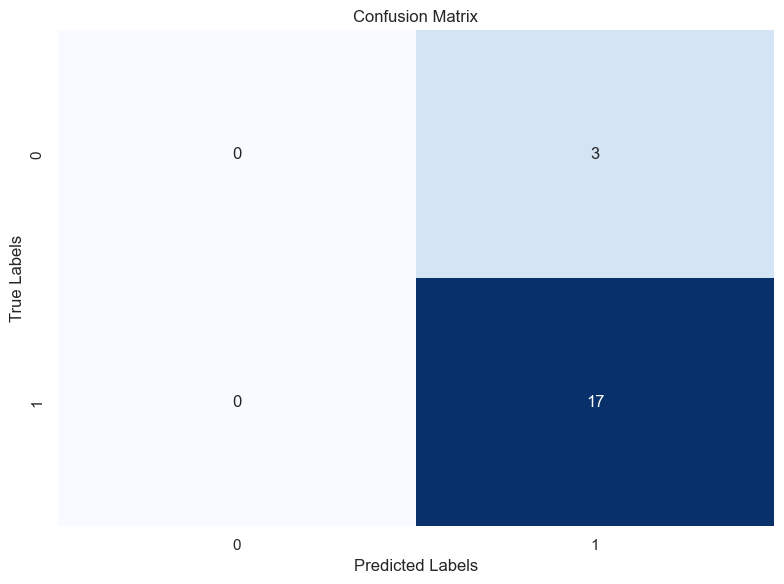

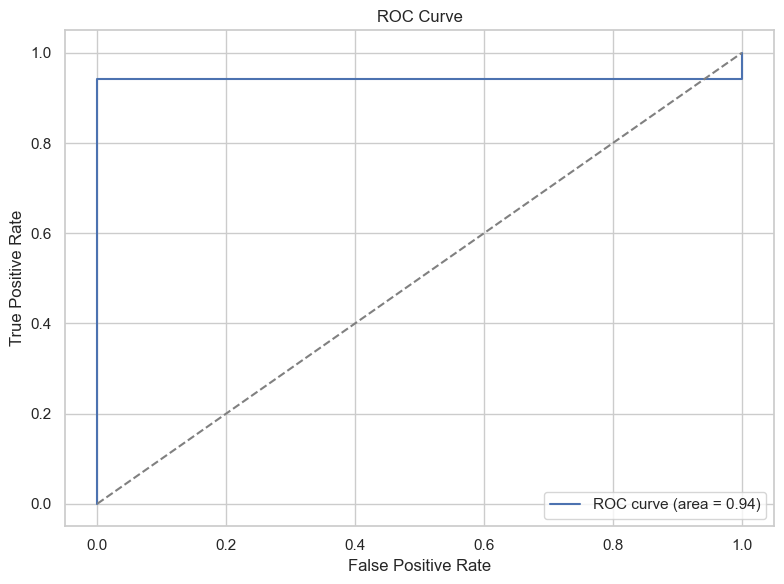

In [5]:
## Predictor Development

# We will try to predict the 'risk_level' based on numeric and selected categorical features

# Select features for the predictor
features = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm', 'birth_head_circumference_cm',
            'age_days', 'weight_kg', 'length_cm', 'head_circumference_cm', 'temperature_c', 'heart_rate_bpm',
            'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_frequency_per_day', 'urine_output_count',
            'stool_count', 'jaundice_level_mg_dl', 'apgar_score']

# Check if all features exist
features = [feat for feat in features if feat in df.columns]

# Remove rows with missing values in features or target. In production, consider imputation instead.
df_model = df.dropna(subset=features + ['risk_level'])

# Encode the target variable
le = LabelEncoder()
df_model['risk_level_encoded'] = le.fit_transform(df_model['risk_level'])

# Standardize numeric features for better model performance
scaler = StandardScaler()
X = scaler.fit_transform(df_model[features])
y = df_model['risk_level_encoded'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Model accuracy on test set: {acc:.2f}')

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

# ROC Curve (if binary classification, else compute for one vs rest)
if len(np.unique(y)) == 2:
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
else:
    print('ROC Curve not produced because the classification is not binary.')

print('Predictor development and evaluation complete.')

## Summary and Future Work

In this notebook, we performed a comprehensive analysis of the newborn health monitoring dataset by:

- Loading and preprocessing data, including inferring date types and handling missing values
- Conducting exploratory data analysis with various plots such as histograms, box plots, pair plots, and a correlation heatmap
- Developing a predictor for the risk level using Random Forest, and evaluating its accuracy along with a confusion matrix (and an ROC curve for binary cases)

While the current approach offers valuable insights, future analyses might include:

- Feature engineering using domain specific knowledge (e.g., combining certain vital signs)
- Testing other classification algorithms or ensemble methods
- Deeper temporal analyses if more time series data becomes available
- Extensive hyperparameter tuning and cross-validation to improve model robustness

Your feedback is appreciated. If this notebook was useful to you, please consider upvoting.